In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import StarPrior
from smc.images import ImageModel
from smc.kernel import MetropolisHastings
from smc.aggregate import Aggregate

import torch
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)
torch.manual_seed(1)

import matplotlib.pyplot as plt

We specify a prior and an image model and generate one image.

count
 10 
fluxes
 [1762.6 1154.3 1419.2 1486.4 1044.6 1154.8 1508.3 1381.  1351.  1360.5
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0. ] 
locs
 [[12.8  3.1]
 [ 3.6 27.2]
 [18.5 30.4]
 [27.3  3.5]
 [23.8 10.4]
 [22.2  6.3]
 [30.6 21.3]
 [ 1.  16.3]
 [26.7  5.4]
 [12.5 17.6]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]] 




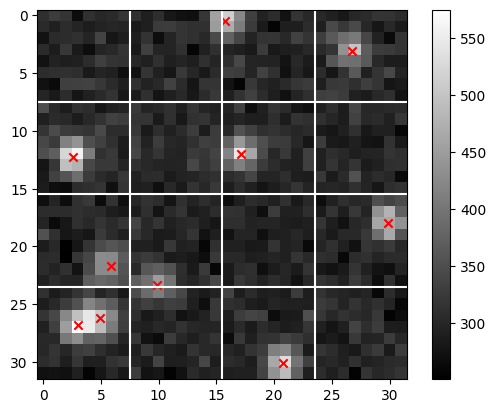

In [2]:
image_dim = 32
true_psf_stdev = 1.0
true_background = 300
true_flux_mean = 1300
true_flux_stdev = 250

TruePrior = StarPrior(max_objects = 20,
                      image_height = image_dim,
                      image_width = image_dim,
                      flux_mean = true_flux_mean,
                      flux_stdev = true_flux_stdev,
                      pad = 2)

TrueImageModel = ImageModel(image_height = image_dim,
                            image_width = image_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

true_counts, true_locs, true_fluxes, images = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

print(f"count\n", true_counts[0].round().item(),
      "\nfluxes\n", true_fluxes[0].round(decimals=1).cpu().numpy(),
      "\nlocs\n", true_locs[0].round(decimals=1).cpu().numpy(), "\n\n")
fig, ax = plt.subplots(1,1)
tmp = ax.imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp)
_ = ax.scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
               true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')
_ = ax.vlines(x = image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.vlines(x = 2*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.vlines(x = 3*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = 2*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = 3*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')

We set the side length of the tiles on which we will run the sampler, and we specify a prior and image model at the tile level. We also specify a Metropolis-Hastings kernel to be used within the SMC sampler.

We'll assume that the image background, PSF standard deviation, and flux prior parameters are all well modeled.

In [3]:
tile_dim = 8

TilePrior = StarPrior(max_objects = 4,
                      image_height = tile_dim,
                      image_width = tile_dim,
                      flux_mean = true_flux_mean,
                      flux_stdev = true_flux_stdev,
                      pad = 2)

TileImageModel = ImageModel(image_height = tile_dim,
                            image_width = tile_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

MHKernel = MetropolisHastings(num_iters = 100,
                              locs_stdev = 0.1,
                              fluxes_stdev = 100,
                              fluxes_min = true_flux_mean - 2.5 * true_flux_stdev,
                              fluxes_max = true_flux_mean + 2.5 * true_flux_stdev)

We initialize an `SMCsampler` object and run it on the tiles.

In [4]:
smc = SMCsampler(image = images[0],
                 tile_dim = tile_dim,
                 Prior = TilePrior,
                 ImageModel = TileImageModel,
                 MutationKernel = MHKernel,
                 num_catalogs_per_count = 2000,
                 ess_threshold = 1500,
                 resample_method = "systematic",
                 max_smc_iters = 100)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)

True count: 10
True total flux: 13622.490234375

Starting the tile samplers...
iteration 5, temperature = 0.01472398079931736
iteration 10, temperature = 0.06016753613948822
iteration 15, temperature = 0.24175220727920532
iteration 20, temperature = 0.8977097272872925
Done!



Now we instantiate an `Aggregate` object with the tile-level SMC results.

In [5]:
aggMH = MetropolisHastings(num_iters = 10,
                           locs_stdev = 0.05,
                           fluxes_stdev = 10,
                           fluxes_min = true_flux_mean - 2.5 * true_flux_stdev,
                           fluxes_max = true_flux_mean + 2.5 * true_flux_stdev)

In [6]:
agg = Aggregate(smc.Prior,
                smc.ImageModel,
                aggMH,
                smc.tiled_image,
                smc.counts,
                smc.locs,
                smc.fluxes,
                smc.weights_intercount,
                resample_method = "multinomial",
                merge_method = "naive",
                merge_multiplier = 1,
                ess_threshold = smc.Prior.max_objects * smc.ess_threshold)

We run the aggregation procedure to obtain image-level catalogs.

In [7]:
agg.run()

level 0
level 1
level 2
iteration 5, temperature = 0.7366341948509216
level 3
iteration 5, temperature = 0.45383375883102417


We examine the posterior distribution of the number of counts.

In [8]:
print(agg.counts.unique(return_counts=True)[0])
print(agg.counts.unique(return_counts=True)[1] / agg.counts.shape[-1])

tensor([10, 11], device='cuda:7')
tensor([0.9540, 0.0460], device='cuda:7')


And we also examine the posterior distribution of the total flux. The dotted black line is the true total flux.

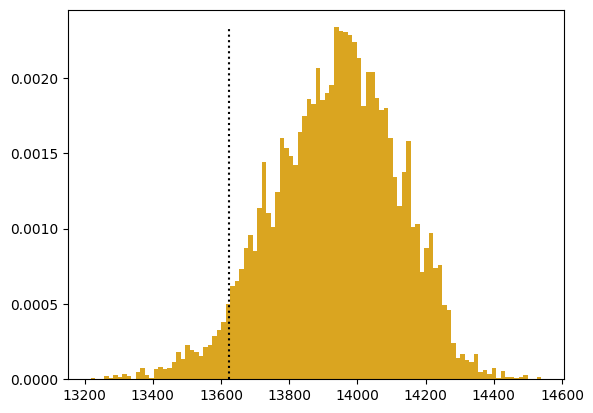

In [9]:
tmp = plt.hist(agg.fluxes[0,0].sum(-1).cpu(), bins = 100, density = True, color = 'goldenrod')
_ = plt.vlines(x = true_fluxes.sum().cpu(), ymin = 0, ymax = tmp[0].max(), color = 'black', linestyle = 'dotted')

Finally, we reconstruct the image using three of our posterior samples.

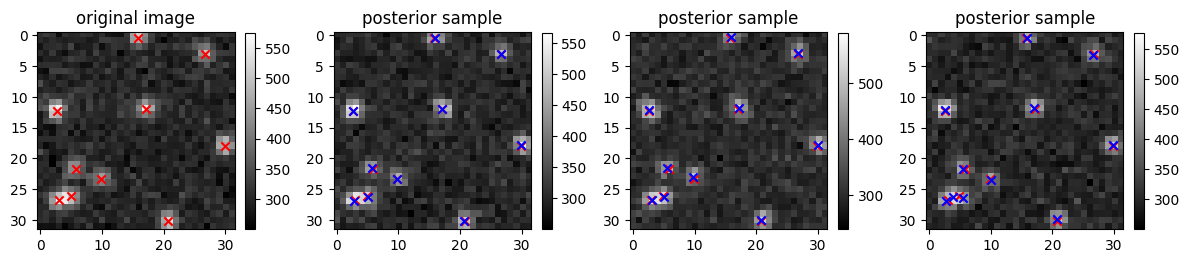

In [10]:
fig, ax = plt.subplots(1, 4, figsize = (12,4))
tmp = ax[0].imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax[0].set_title('original image')
_ = ax[0].scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                  true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')

for j in range(1,4):
    index = torch.randint(low = 0, high = agg.counts.shape[-1] - 1, size = [1])
    psf = agg.ImageModel.psf(agg.locs[:,:,index])
    rate = (psf * agg.fluxes[:,:,index].unsqueeze(-3).unsqueeze(-4)).sum(-1) + agg.ImageModel.background
    reconstruction = torch.distributions.Poisson(rate).sample().squeeze([0,1]).permute((2,0,1))
    tmp = ax[j].imshow(reconstruction[0].cpu(), cmap = 'gray')
    _ = ax[j].set_title('posterior sample')
    _ = fig.colorbar(tmp, fraction = 0.045)
    _ = ax[j].scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                    true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')
    _ = ax[j].scatter(agg.locs.squeeze()[index,:agg.counts.squeeze()[index],1].cpu() - 0.5,
                    agg.locs.squeeze()[index,:agg.counts.squeeze()[index],0].cpu() - 0.5, marker = 'x', color = 'blue')

fig.tight_layout()